In [1]:
import numpy as np
import matplotlib.pyplot as plt 

In [7]:
def dot(a, b):
    return np.einsum('ijk,ikl->ijl', a, b)

def Aterm(N, h, m, k, dW):
    """kth term in the sum of Wiktorsson2001 equation (2.2)"""
    sqrt2h = np.sqrt(2.0/h)
    Xk = np.random.normal(0.0, 1.0, (N, m, 1))
    Yk = np.random.normal(0.0, 1.0, (N, m, 1))
    term1 = dot(Xk, (Yk + sqrt2h*dW).transpose((0, 2, 1)))
    term2 = dot(Yk + sqrt2h*dW, Xk.transpose((0, 2, 1)))
    return (term1 - term2)/k


def Ikpw(dW, h, n=5):
    """matrix I approximating repeated Ito integrals for each of N time
    intervals, based on the method of Kloeden, Platen and Wright (1992).
    Args:
      dW (array of shape (N, m)): giving m independent Weiner increments for
        each time step N. (You can make this array using sdeint.deltaW())
      h (float): the time step size
      n (int, optional): how many terms to take in the series expansion
    Returns:
      (A, I) where
        A: array of shape (N, m, m) giving the Levy areas that were used.
        I: array of shape (N, m, m) giving an m x m matrix of repeated Ito 
        integral values for each of the N time intervals.
    """
    N = dW.shape[0]
    m = dW.shape[1]
    if dW.ndim < 3:
        dW = dW.reshape((N, -1, 1)) # change to array of shape (N, m, 1)
    if dW.shape[2] != 1 or dW.ndim > 3:
        raise(ValueError)
    A = Aterm(N, h, m, 1, dW)
    for k in range(2, n+1):
        A += Aterm(N, h, m, k, dW)
    A = (h/(2.0*np.pi))*A
    I = 0.5*(dot(dW, dW.transpose((0,2,1))) - np.diag(h*np.ones(m))) + A
    dW = dW.reshape((N, -1)) # change back to shape (N, m)
    return (A, I)

In [43]:
def RosslerSRI2(f, G, y0, times, dt):
    """Implements the Roessler2010 order 1.0 strong Stochastic Runge-Kutta

      IJmethod (callable): which function to use to generate repeated
        integrals. N.B. for an Ito equation, must use an Ito version here
        (either Ikpw or Iwik). For a Stratonovich equation, must use a
        Stratonovich version here (Jkpw or Jwik).
      dW: optional array of shape (len(tspan)-1, d). 
      IJ: optional array of shape (len(tspan)-1, m, m).
        Optional arguments dW and IJ are for advanced use, if you want to
        use a specific realization of the d independent Wiener processes and
        their multiple integrals at each time step. If not provided, suitable
        values will be generated randomly.
    """
    #(d, m, f, G, y0, tspan, dW, IJ) = _check_args(f, G, y0, tspan, dW, IJ)
    N = len(times)
    d = 7
    m = 7
    
    #dW = np.random.normal(0,np.sqrt(dt), (N-1, m))
    np.random.seed(1)
    dW = np.zeros((len(times), 7))
    for k in range(len(times)):
        w0 = np.random.normal()*np.sqrt(dt)
        w1 = np.random.normal()*np.sqrt(dt)
        dW[k,:] = np.array([w0, w1, w0, w1 , 0.,0.,0.])
    
    #_, I = Ikpw(dW, dt)
    _,I=Ikpw(dW,dt)
    # allocate space for result
    y = np.zeros((N, d))
    y[0] = y0;
    Gn = np.zeros((d, m), dtype=y.dtype)
    
    for ind, t in enumerate(times[:-1]):
        Yn = y[ind] # shape (d,)
        Ik = dW[ind,:] # shape (m,)
        
        Iij = I[ind,:,:] # shape (m, m)
        fnh = f(Yn, t)*dt # shape (d,)
        
        Gn = G(Yn, t)
        sum1 = np.dot(Gn, Iij)/np.sqrt(dt) # shape (d, m)
        
        H20 = Yn + fnh # shape (d,)
        H20b = np.reshape(H20, (d, 1))
        H2 = H20b + sum1 # shape (d, m)
        
        H30 = Yn
        H3 = H20b - sum1
        fn1h = f(H20, times[ind+1])*dt
        Yn1 = Yn + 0.5*(fnh + fn1h) + np.dot(Gn, Ik)
        for k in range(0, m):
            Yn1 += 0.5*np.sqrt(dt)*(G(H2[:,k], times[ind+1])[:,k] - G(H3[:,k], times[ind+1])[:,k])
        y[ind+1] = Yn1
    return y

In [44]:
def Fs(s,t):
    x = s[0:2]
    xdot = np.dot(A,x)
    
    y = s[2:4]
    ydot = np.dot(C,x)
    
    varx, varp,covxp = s[4:]
    
    varx_dot = ((0.5 + n)*gamma) - (varx*gamma) + Lambda - (4*eta*Lambda*covxp**2)  - ((0.5+n)*gamma  + Lambda + (2*varx*np.sqrt(eta*Lambda)))**2 + (2*covxp*omega)
    varp_dot = ((0.5 + n)*gamma) - (varp*gamma) + Lambda - (4*eta*Lambda*covxp**2) -  ((0.5+n)*gamma + Lambda + (2*varp*np.sqrt(eta*Lambda)))**2 - (2*covxp*omega)
    covxp_dot = covxp*(-(4*eta*varp) - (4*varx*eta) - (4*np.sqrt(eta*Lambda))  ) + covxp*gamma*(-1 -2*np.sqrt(eta*Lambda) - (4*n*np.sqrt(eta*Lambda))) + (varp*omega - varx*omega)
        
    return np.array([xdot[0], xdot[1], ydot[0],  ydot[1], varx_dot, varp_dot, covxp_dot])


def s_to_cov(s,begin_cov=4):
    varx, varp,covxy = s[begin_cov:]
    cov = np.array([[varx, covxy], [covxy, varp]])
    return cov


def Gs(s,t):
    cov = s_to_cov(s)
    XiCov = np.dot(cov, C.T) + D.T
    wieners = np.zeros((s.shape[0], s.shape[0]))
    wieners[:2,:2]  = XiCov
    wieners[2:4,2:4] = np.eye(2)
    return wieners

In [45]:
x0 = 0.
p0 = 0.
yx0 = 0.
yp0 = 0.
varx0 = 1.
varp0 = 1.
covxy0 = 0.
s0 = np.array([x0, p0, yx0, yp0, varx0, varp0,covxy0])
np.random.seed(1)


periods = 1
ppp = 10000
dt = 1/ppp
times = np.arange(0.,periods+dt,dt)

eta = 1
gamma = 0.3
Lambda = 0.8
omega = 2*np.pi
n = 10

A = np.array([[-.5*gamma, omega], [-omega, -0.5*gamma]])
D = np.diag([(gamma*(n+0.5)) + Lambda]*2)
C = np.diag([np.sqrt(4*eta*Lambda)]*2)

In [46]:
solutionRossler = RosslerSRI2(Fs, Gs, s0, times, dt)

In [47]:
def convert_solution(ss):
    states = ss[:,0:2]

    signals = ss[:,2:4]
    signals = signals[1:] - signals[:-1]

    covss = ss[:,-3:]
    covs = [s_to_cov(s,begin_cov=0) for s in covss]

    return states, signals, covs

In [48]:
statesR, signalsR, covsR = convert_solution(solutionRossler)

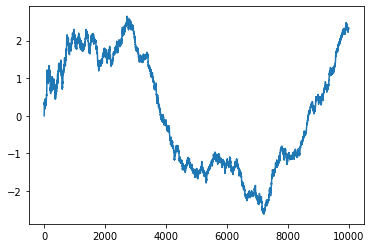

In [49]:
plt.plot(statesR[:,0])

Now let's check the Euler using the dy's

In [50]:
from tqdm import tqdm
from misc import ct
xi = lambda cov,D: np.dot(cov, ct(C)) + ct(D)

ExpA = np.array([[np.cos(omega*dt), -np.sin(omega*dt)], [np.sin(omega*dt), np.cos(omega*dt)]])*np.exp(-gamma*dt/2)

def evolve_simu_state(x, sigma, dy):
    cov = sigma
    XiCov = xi(cov, D)
    dx = np.dot(A-np.dot(XiCov,C),x)*dt   + np.dot(XiCov,dy)# 
    #dx = np.dot(ExpA-np.eye(2), x) - np.dot(np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
    dcov = (np.dot(A,cov) + np.dot(cov, ct(A)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update
    return [x + dx, cov + dcov]

sstates = [statesR[0]]
scovs = [covsR[0]]

for ind,dy in enumerate(tqdm(signalsR)):
    simu = evolve_simu_state(sstates[-1],scovs[-1], dy)
    sstates.append(simu[0])
    scovs.append(simu[1])#[ind+1])

100%|██████████| 10000/10000 [00:00<00:00, 36295.34it/s]


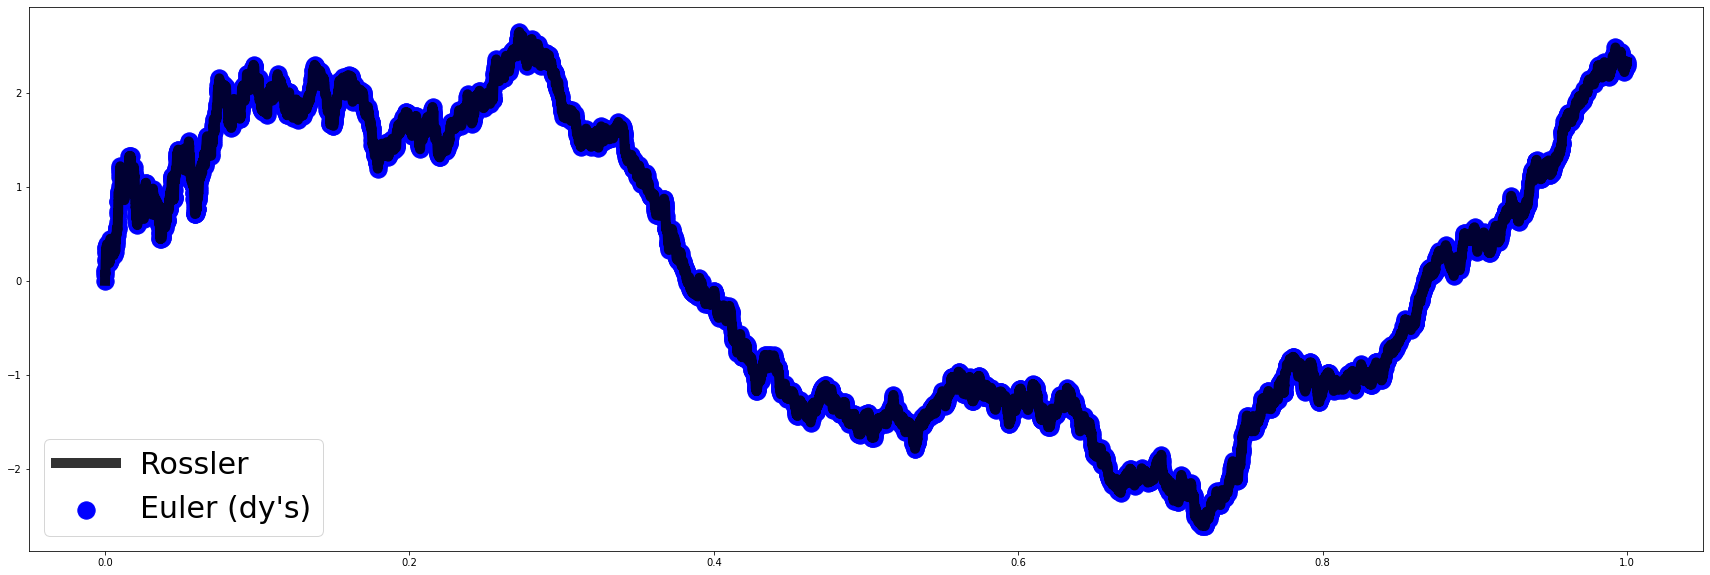

In [52]:
plt.figure(figsize=(30,10))
T=-1
plt.scatter(times[:T],np.array(sstates)[:,0][:T], s=300,color="blue", label="Euler (dy's)")
plt.plot(times[:T],statesR[:,0][:T],color="black", linewidth=10, alpha=.8, label="Rossler")
plt.legend(prop={"size":30})